In [1]:
from __future__ import absolute_import, print_function, division, unicode_literals #menghilangkan perbedaan antara tipe string dan unicode #jika kita melakukan pembagian antara dua bilangan bulat (integer) menghasilkan bil bulat int
import os.path # untuk memanipulasi jalur file dan direktori (path)
import glob #untuk mencari file yang cocok (contoh txt)
import shutil #digunakan untuk melakukan operasi penyalinan file.

import tensorflow as tf # untuk membangun dan melatih model neural network.
assert tf.__version__.startswith('2') #untuk memverifikasi bahwa versi TensorFlow yang digunakan adalah versi 2.

from tensorflow import keras # keras digunakan untuk mendefinisikan dan melatih model neural network.
from tensorflow.keras.models import Sequential #Sequential memungkinkan kita untuk menambahkan lapisan-lapisan (layers) secara berurutan pada model kita.
from tensorflow.keras.preprocessing.image import ImageDataGenerator #Kelas ImageDataGenerator digunakan untuk melakukan augmentasi data gambar secara real-time saat melatih model. 
from tensorflow.keras.layers import Conv2D, Flatten, MaxPooling2D, Dropout, Dense, Activation
#konvolusi 2D ini berfungsi untuk mengekstraksi fitur-fitur dari data gambar.
# flatten berfungsi untuk mengubah array multidimensi menjadi vektor satu dimensi.
# max pooling 2D ini berfungsi untuk mereduksi dimensi spasial data dengan mempertahankan fitur-fitur paling signifikan.
# Dropout membantu mencegah overfitting dan meningkatkan generalisasi.
#Activation digunakan untuk menambahkan lapisan aktivasi pada model neural network.

from keras import regularizers #regularizers berfungsi memperkuat generalisasi model terhadap data baru.

import numpy as np #NumPy juga sering digunakan dalam pengolahan gambar dan vision, di mana gambar biasanya direpresentasikan sebagai array numerik
import matplotlib.pyplot as plt #membuat visualisasi atau grafik dalam Python
import pathlib #pathlib menyediakan fungsi-fungsi yang bermanfaat dalam memanipulasi jalur file dan direktori

from skimage.feature import corner_harris, corner_peaks #Modul skimage menyediakan algoritma-algoritma untuk ekstraksi fitur dari gambar. Dalam kode ini, corner_harris dan corner_peaks digunakan untuk mendeteksi sudut pada gambar.
from sklearn.neighbors import KNeighborsClassifier # KNeighborsClassifier digunakan untuk membuat dan melatih model k-NN.
from sklearn.metrics import accuracy_score #menyediakan fungsi-fungsi untuk mengukur performa model. Dalam kode ini, accuracy_score digunakan untuk menghitung akurasi dari model k-NN.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
BATCH_SIZE = 8    #setiap kali model diperbarui, akan digunakan 8 sampel data sebelumnya
IMG_HEIGHT = 224  #tinggi gambar akan diatur menjadi 224 piksel.
IMG_WIDTH = 224   #lebar gambar akan diatur menjadi 224 piksel.

In [4]:
data_dir = "/content/drive/MyDrive/PCVK_MM/Images/Rice Leaf Disease/"
data_dir = pathlib.Path(data_dir)

In [5]:
# mendefinisikan variabel CLASS_NAMES sebagai array NumPy dengan tiga elemen. 
CLASS_NAMES = np.array(['Leaf Blight', 'Brown Spot', 'Leaf Smut'])

print('Class Names:', CLASS_NAMES)

Class Names: ['Leaf Blight' 'Brown Spot' 'Leaf Smut']


In [6]:
train_path = '/content/drive/MyDrive/PCVK_MM/Images/Rice Leaf Disease/' # jalur (path) ke direktori yang berisi data latihan (training data) 
test_path = '/content/drive/MyDrive/PCVK_MM/Images/Rice Leaf Disease/' # data pengujian (testing data) juga tersedia dalam direktori yang sama seperti data latihan. 

In [7]:
# mempersiapkan generator data latihan dan pengujian yang akan digunakan dalam pelatihan dan evaluasi model.
image_train_gen = ImageDataGenerator(rescale=1./255, # membuat objek ImageDataGenerator yang akan digunakan untuk melakukan augmentasi data pada data latihan
                                     zoom_range=0.50, #penskalaan ulang (rescale), zoom, rotasi, flipping horizontal, serta pergeseran lebar dan tinggi gambar.
                                     rotation_range=45,
                                     horizontal_flip=True,
                                     width_shift_range=0.15,
                                     height_shift_range=0.15) 

# membuat generator data latihan menggunakan objek ImageDataGenerator yang telah dibuat sebelumnya.
train_data_gen = image_train_gen.flow_from_directory(train_path, #train_path: jalur (path) direktori yang berisi data latihan 
                                                     shuffle=True, # menentukan apakah data akan diacak sebelum setiap epoch saat pelatihan.
                                                     batch_size=BATCH_SIZE, # menentukan ukuran batch yang akan digunakan saat melatih model.
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH), #menentukan ukuran target (tinggi dan lebar) untuk mengubah semua gambar dalam dataset latihan menjadi ukuran yang seragam.
                                                     class_mode='sparse') # Nilai 'sparse' digunakan saat kelas target adalah bilangan bulat,
                                                     
#membuat objek ImageDataGenerator untuk melakukan penskalaan ulang (rescale) pada data pengujian (testing data).
img_val_gen = ImageDataGenerator(rescale=1./255)
val_data_gen = img_val_gen.flow_from_directory(test_path,
                                               batch_size=BATCH_SIZE,
                                               target_size=(IMG_HEIGHT, IMG_WIDTH),
                                               class_mode='sparse')



Found 120 images belonging to 3 classes.
Found 120 images belonging to 3 classes.


In [8]:
class myCallback(tf.keras.callbacks.Callback): # menentukan fungsi-fungsi callback yang akan dijalankan 
    def on_epoch_end(self, epoch, logs={}): #mendefinisikan metode on_epoch_end dalam kelas myCallback
        if logs.get('accuracy') > 0.90: #mengevaluasi kondisi, yaitu jika akurasi (accuracy) yang ada dalam logs (rekaman metrik pelatihan) lebih besar dari 0.90.
            print('\nAkurasi mencapai 90%') # mencetak "Akurasi mencapai 90%" jika kondisi di atas terpenuhi.
        print(f"Epoch {epoch+1} - Loss: {logs['loss']:.4f} - Accuracy: {logs['accuracy']:.4f} - Val Loss: {logs['val_loss']:.4f} - Val Accuracy: {logs['val_accuracy']:.4f}") # mengatur atribut stop_training dari model menjadi True, yang akan menghentikan pelatihan model.

callbacks = myCallback()

In [9]:
# menampilkan beberapa gambar daun padi dalam bentuk grid

def plotImages(image_arr): # menerima array gambar sebagai input dan menampilkannya dalam grid
    fig, axes = plt.subplots(1, 5, figsize=(20, 20)) # membuat grid dengan 1 baris dan 5 kolom, yang akan menampung 5 gambar. 
    axes = axes.flatten() # meratakan array axes menjadi array 1 dimensi. 
    for img, ax in zip(image_arr, axes): #memungkinkan kita untuk mengambil gambar dari image_arr dan sumbu (axis) yang sesuai dari axes saat melakukan iterasi.
        ax.imshow(img)
    plt.tight_layout() # mengatur tata letak (layout) 
    plt.show()

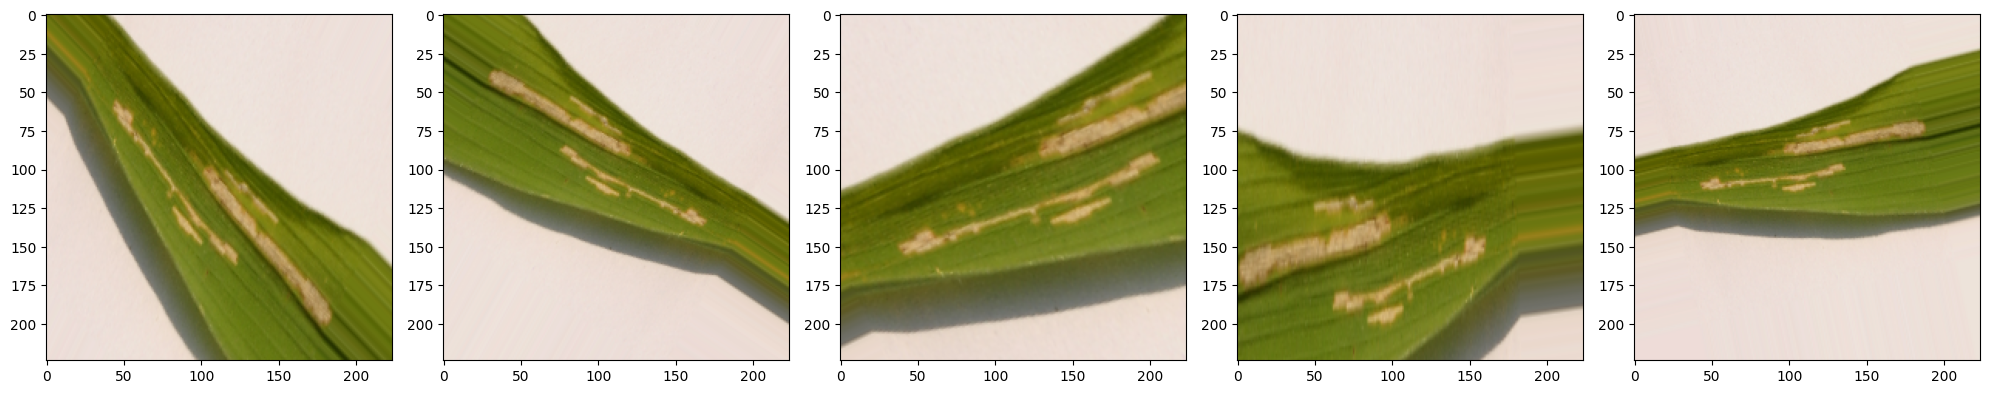

In [10]:
# mengambil beberapa gambar dari data latihan
img_array = [train_data_gen[0][0][0] for i in range(5)] # membuat sebuah array img_array yang berisi 5 gambar.
plotImages(img_array)


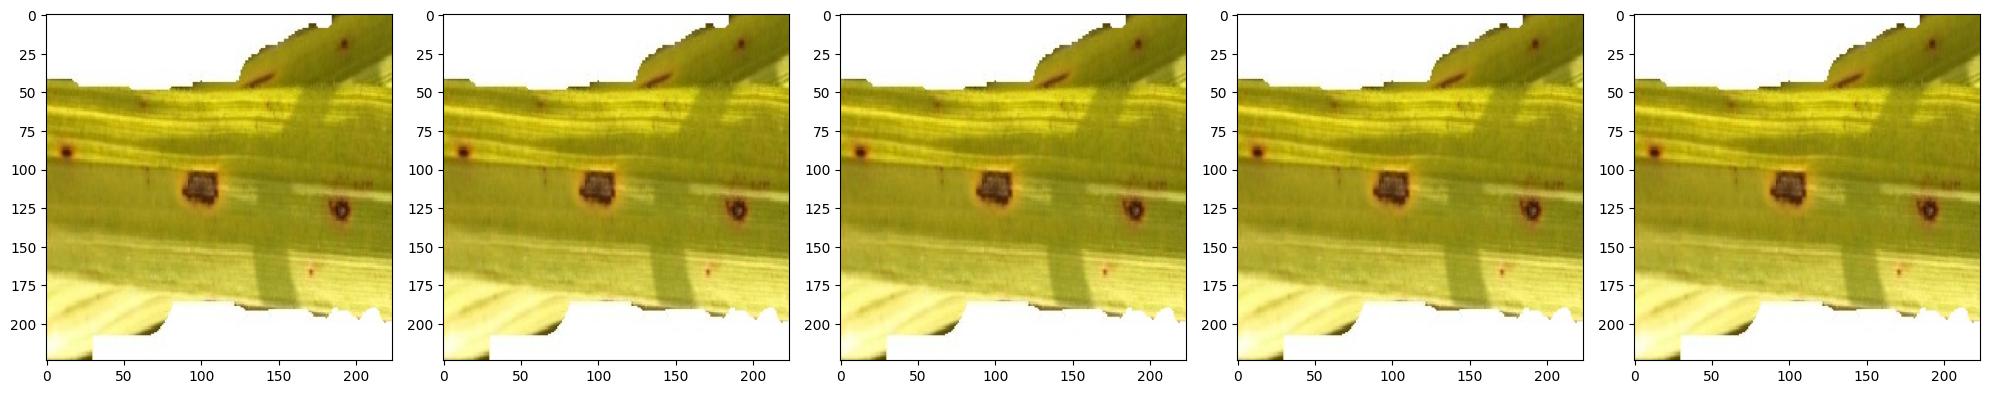

In [11]:
#  mengambil beberapa gambar dari data validasi 
#val_data_gen adalah generator data validasi yang digunakan untuk menghasilkan batch-batch citra validasi.
#val_data_gen[0] mengakses batch pertama dari generator data validasi.
#val_data_gen[0][0] mengakses citra pertama dalam batch pertama.
#val_data_gen[0][0][0] mengakses elemen piksel pertama dalam citra pertama.
img_array = [val_data_gen[0][0][0] for i in range(5)]
plotImages(img_array)

#**Ekstraksi Fitur**

In [12]:
# Ekstrak fitur menggunakan deteksi sudut
def extract_features(image):
    gray = tf.image.rgb_to_grayscale(image) #mengonversi gambar dari format RGB menjadi format grayscale
    gray = tf.squeeze(gray) # memastikan gray memiliki dimensi yang sesuai untuk langkah berikutnya.
    corners = corner_peaks(corner_harris(gray), min_distance=5) #mendeteksi sudut-sudut pada gambar grayscale
    return corners.shape[0] #mengembalikan nilai yang berhasil mendeteksi jumlah sudut

In [13]:
# Prepare training data
X_train = [] #  menyimpan fitur-fitur gambar
y_train = [] # menyimpan label kelas

for images, labels in train_data_gen: # Setiap batch akan terdiri dari batch gambar (images) dan label kelas (labels).
    for i in range(len(images)): # memulai loop for yang akan mengiterasi melalui setiap gambar dan label dalam batch.
        features = extract_features(images[i]) # mengambil fitur dari gambar 
        X_train.append(features) # menambahkan fitur-fitur gambar
        y_train.append(labels[i]) # menambahkan label kelas 
    
    if len(X_train) >= len(train_data_gen.classes): # memeriksa apakah sudah cukup banyak gambar dan label yang telah diambil. 
        break

X_train = np.array(X_train)
y_train = np.array(y_train) # mengubah list X_train dan y_train menjadi array NumPy untuk pemodelan

In [14]:
# Prepare validation data
X_val = []
y_val = []

for images, labels in val_data_gen:
    for i in range(len(images)):
        features = extract_features(images[i])
        X_val.append(features)
        y_val.append(labels[i])
    
    if len(X_val) >= len(val_data_gen.classes):
        break

X_val = np.array(X_val)
y_val = np.array(y_val)

#**Training**

In [15]:
# Train K-Nearest Neighbors classifier 

knn = KNeighborsClassifier(n_neighbors=3) # menentukan jumlah neighbors terdekat yang akan digunakan untuk melakukan klasifikasi.
knn.fit(X_train.reshape(-1, 1), y_train.reshape(-1, 1)) # mengubah fitur menjadi bentuk dengan 1 kolom 

/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


KNeighborsClassifier(n_neighbors=3)

In [16]:
#  menghitung akurasi prediksi model KNN pada data validasi dan mencetaknya ke layar

val_predictions = knn.predict(X_val.reshape(-1, 1)) # Baris ini memprediksi kelas target (variabel dependen) pada data validasi (X_val) 
val_accuracy = accuracy_score(y_val, val_predictions) # menghitung akurasi prediksi pada data validasi.

In [17]:
# Model building
# Instantiating a convnet
model = Sequential() # menginisialisasi model sebagai objek Sequential (membangun model neural network berurutan)
model.add(Conv2D(16, (3, 3), input_shape=(224, 224, 3), activation="relu")) # menentukan dimensi input gambar (224x224 piksel dengan 3 saluran warna RGB).
model.add(MaxPooling2D(pool_size=(2, 2))) # melakukan operasi pemaximuman pada jendela 2x2.
model.add(Conv2D(32, (3, 3), activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))# melakukan operasi pemaximuman pada jendela 2x2.
model.add(Conv2D(64, (3, 3), activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten()) # meratakan output dari layer sebelumnya menjadi vektor 1 dimensi
model.add(Dropout(0.2)) # mengurangi overfitting dengan secara acak mengabaikan sebagian output unit pada saat pelatihan.
model.add(Dense(128, activation="relu")) # menambahkan layer Dense (fully connected) dengan 128 unit dan fungsi aktivasi ReLU.
model.add(Dropout(0.2)) 
model.add(Dense(3, activation="softmax")) # menghasilkan probabilitas prediksi untuk masing-masing kelas.

# mengkonfigurasi proses pelatihan model dengan memilih optimizer (adam), loss function (sparse_categorical_crossentropy), dan metrik yang akan digunakan (akurasi).
model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=['accuracy']
)

model.summary() # mencetak ringkasan (summary) dari arsitektur model, termasuk jumlah parameter yang dapat diatur dalam proses pelatihan.

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 26, 26, 64)       0

In [18]:
#  menginisialisasi pelatihan model dengan data generator. 

EPOCHS = 70# mendefinisikan jumlah EPOCHS atau iterasi yang akan dilakukan selama proses pelatihan. Setiap EPOCHS akan melibatkan pemrosesan seluruh dataset pelatihan.
history = model.fit_generator(train_data_gen, epochs=EPOCHS, validation_data=val_data_gen, callbacks=[callbacks]) #  menjalankan proses pelatihan pada model menggunakan data generator.

<ipython-input-18-d029a273cd6f>:4: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_data_gen, epochs=EPOCHS, validation_data=val_data_gen, callbacks=[callbacks]) #  menjalankan proses pelatihan pada model menggunakan data generator.


Epoch 1/70
15/15 [==============================] - 23s 1s/step - loss: 1.3227 - accuracy: 0.4250 - val_loss: 1.0186 - val_accuracy: 0.5000
Epoch 2/70
15/15 [==============================] - 24s 2s/step - loss: 1.0493 - accuracy: 0.4333 - val_loss: 0.9665 - val_accuracy: 0.5083
Epoch 3/70
15/15 [==============================] - 23s 2s/step - loss: 1.0291 - accuracy: 0.4833 - val_loss: 0.9646 - val_accuracy: 0.4833
Epoch 4/70
15/15 [==============================] - 24s 2s/step - loss: 1.0247 - accuracy: 0.4583 - val_loss: 0.9097 - val_accuracy: 0.6917
Epoch 5/70
15/15 [==============================] - 19s 1s/step - loss: 0.9290 - accuracy: 0.5500 - val_loss: 0.7842 - val_accuracy: 0.6333
Epoch 6/70
15/15 [==============================] - 21s 1s/step - loss: 0.8966 - accuracy: 0.5917 - val_loss: 0.7571 - val_accuracy: 0.7250
Epoch 7/70
15/15 [==============================] - 20s 1s/step - loss: 0.8235 - accuracy: 0.6167 - val_loss: 0.6958 - val_accuracy: 0.7667
Epoch 8/70
15/15 [==

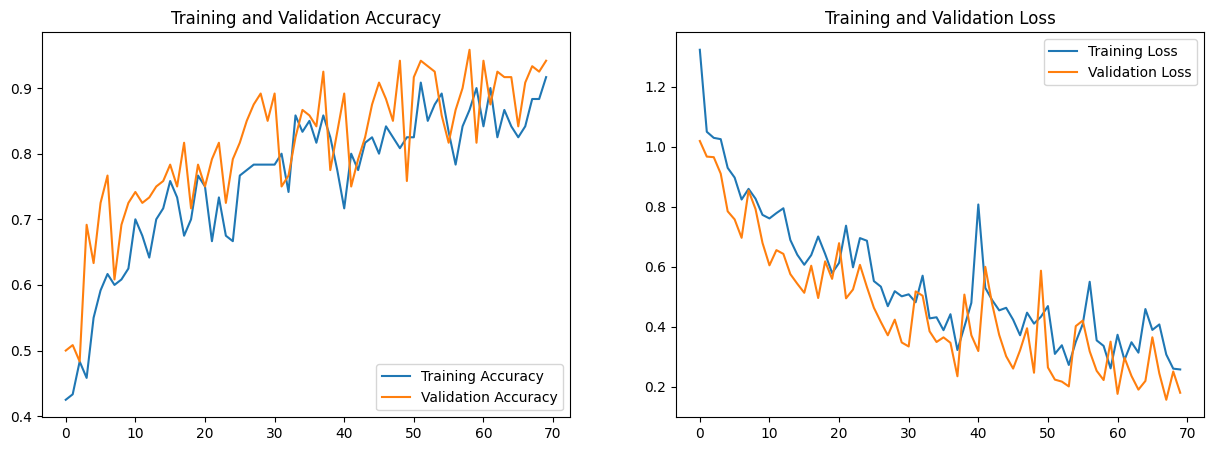

In [19]:

# Plot training and validation graphs
acc = history.history['accuracy'] # mengambil nilai akurasi pelatihan dari history (variabel yang menyimpan riwayat pelatihan model).
val_accuracy = history.history['val_accuracy'] # mengambil nilai akurasi validasi dari history

loss = history.history['loss'] # mengambil nilai loss (kerugian) pelatihan dari history
val_loss = history.history['val_loss'] # mengambil nilai loss validasi dari history.

epochs_range = range(EPOCHS) # menginisialisasi rentang nilai EPOCHS sebagai objek range.

# memvisualisasikan akurasi pelatihan dan validasi seiring dengan peningkatan EPOCHS

plt.figure(figsize=(15, 5)) # membuat sebuah figure dengan ukuran (15, 5) untuk menampung grafik yang akan digambar.
plt.subplot(1, 2, 1) #  menentukan subplot pertama dengan tata letak 1 baris dan 2 kolom
plt.plot(epochs_range, acc, label='Training Accuracy') # menggambar grafik untuk akurasi pelatihan dengan menggunakan nilai EPOCHS sebagai sumbu x dan nilai akurasi pelatihan sebagai sumbu y.
plt.plot(epochs_range, val_accuracy, label='Validation Accuracy') # menggambar grafik untuk akurasi validasi dengan menggunakan nilai EPOCHS sebagai sumbu x dan nilai akurasi validasi sebagai sumbu y.
plt.legend(loc='lower right') # menambahkan legend ke grafik untuk menyatakan label dari setiap garis (Training Accuracy dan Validation Accuracy).
plt.title('Training and Validation Accuracy') # memberikan judul pada subplot yang menampilkan grafik akurasi pelatihan dan validasi.

# memvisualisasikan loss pelatihan dan validasi seiring dengan peningkatan EPOCHS. 
plt.subplot(1, 2, 2) # menentukan subplot kedua dan menetapkan subplot yang sedang aktif sebagai subplot kedua.
plt.plot(epochs_range, loss, label='Training Loss') # menggambar grafik untuk loss pelatihan dengan menggunakan nilai EPOCHS sebagai sumbu x dan nilai loss pelatihan sebagai sumbu y.
plt.plot(epochs_range, val_loss, label='Validation Loss') # menggambar grafik untuk loss validasi dengan menggunakan nilai EPOCHS sebagai sumbu x dan nilai loss validasi sebagai sumbu y.
plt.legend(loc='upper right') #menambahkan legend ke grafik untuk menyatakan label dari setiap garis (Training Loss dan Validation Loss).
plt.title('Training and Validation Loss') # memberikan judul pada subplot yang menampilkan grafik loss pelatihan dan validasi.
plt.show()

In [20]:
def preprocess_image(image_path): # mendefinisikan sebuah fungsi dengan nama preprocess_image yang menerima parameter image_path, yaitu path/lokasi dari gambar yang akan diproses.
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=(IMG_HEIGHT, IMG_WIDTH))
    img_array = tf.keras.preprocessing.image.img_to_array(img) # untuk menentukan ukuran target dari gambar yang dimuat. 
    return img_array #  mengembalikan array gambar yang telah diproses sebagai output dari fungsi.

In [21]:
#  mengembalikan hasil prediksi sebagai output dari fungsi.

def predict_image_class(image_array): # mendefinisikan sebuah fungsi dengan nama predict_image_class yang menerima parameter image_array, yaitu array gambar yang telah diproses sebelumnya.
    features = extract_features(image_array) # mengembalikan fitur-fitur yang relevan dari array gambar.
    prediction = knn.predict([features]) # fitur tersebut diberikan sebagai input ke fungsi predict dengan menggunakan tanda kurung kotak ([features]) agar sesuai dengan format yang diperlukan oleh model.
    return prediction #  mengembalikan hasil prediksi yang telah diperoleh sebagai output dari fungsi.


Saving DSC_0385.jpg to DSC_0385.jpg
1/1 [==============================] - 0s 38ms/step


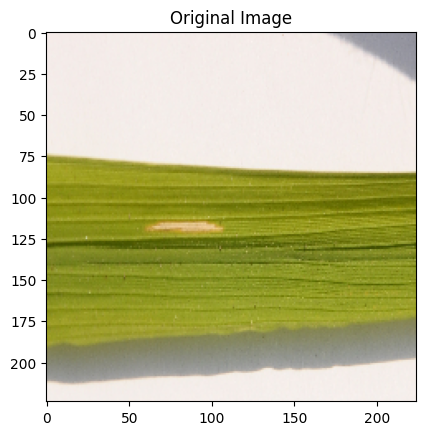

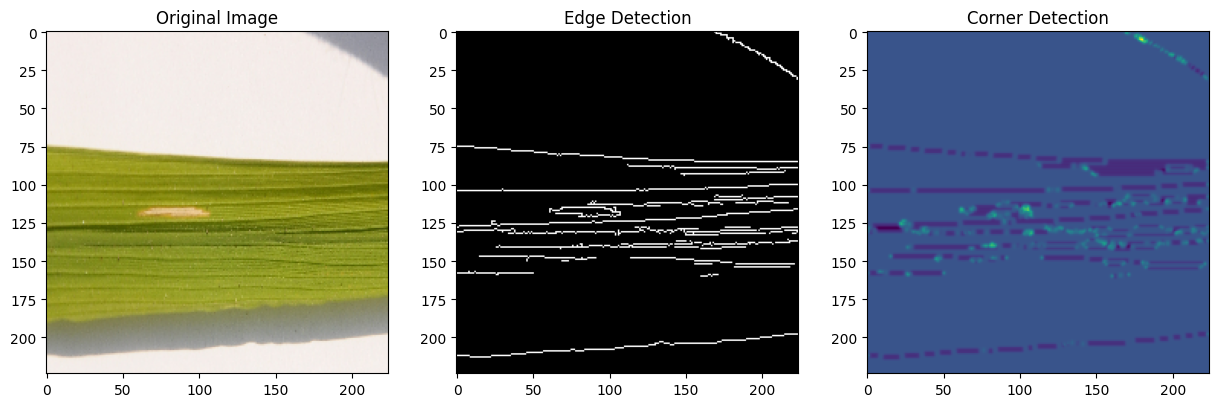

DSC_0385.jpg
This image belongs to class: Leaf Blight


In [26]:
# memuat, memproses, dan memprediksi kelas/gambar dari gambar yang diunggah.
from google.colab import files
import cv2 # mengimpor modul OpenCV yang digunakan untuk operasi pengolahan citra.
from tensorflow.keras.preprocessing import image

uploaded = files.upload() # mengunggah gambar yang akan diproses. 

for fn in uploaded.keys(): # memulai loop untuk setiap gambar yang diunggah.
    # Preprocess and predict image class
    img = image.load_img(fn, target_size=(IMG_HEIGHT, IMG_WIDTH)) # memuat gambar dengan menggunakan load_img dari modul image (asumsi bahwa modul image telah diimpor sebelumnya).
    img_array = image.img_to_array(img) # mengonversi gambar yang telah dimuat menjadi array dengan menggunakan fungsi img_to_array dari modul image.
    img_resized = img_array / 255.0 # mengubah nilai piksel gambar menjadi rentang antara 0 dan 1 dengan membagi setiap elemen array gambar (img_array) dengan 255.0.
    image_array = np.expand_dims(img_resized, axis=0) # menambahkan dimensi baru pada array gambar (img_resized) di sepanjang sumbu 0.

    prediction = model.predict(image_array) # Baris ini memprediksi kelas/gambar berdasarkan array gambar yang telah diproses sebelumnya dengan menggunakan model yang telah didefinisikan sebelumnya (model).
    predicted_class_index = np.argmax(prediction[0]) # mengambil indeks kelas dengan nilai prediksi tertinggi dari hasil prediksi (prediction) dengan menggunakan fungsi argmax dari modul NumPy.
    predicted_class = CLASS_NAMES[predicted_class_index] # mengambil nama kelas yang sesuai dengan indeks kelas yang telah diprediksi dari array CLASS_NAMES.

    # Display image and predicted class
    imgplot = plt.imshow(img) # menampilkan gambar asli menggunakan fungsi imshow dari modul plt (asumsi bahwa modul plt telah diimpor sebelumnya).
    plt.title('Original Image')
    plt.show()

    # Convert PIL image to OpenCV format
    img_cv = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)

    # Edge Detection
    gray = cv2.cvtColor(img_cv, cv2.COLOR_BGR2GRAY)
    edges = cv2.Canny(gray, 100, 200)

    # Corner Detection
    corners = corner_harris(edges)

    # Display the original image, edges, and corners
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    axes[0].imshow(img)
    axes[0].set_title('Original Image')
    axes[1].imshow(edges, cmap='gray')
    axes[1].set_title('Edge Detection')
    axes[2].imshow(corners)
    axes[2].set_title('Corner Detection')
    plt.show()

    print(fn)
    print('This image belongs to class:', predicted_class)
